In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import pymc3 as pm
from pymc3 import glm
import arviz as az
sns.set()

### 2A

In [2]:
X = np.load("X.pkl", allow_pickle = True)

In [3]:
X

array([[ -2.56445884,  -6.2596728 , -16.25042218, ...,   8.10215072,
         -7.50834754,   0.32397542],
       [-11.79846811,   5.44878821,  -7.15530844, ...,  11.40527105,
         20.85347419, -17.48384596],
       [-12.16988086,  -2.20841284,  -7.23722244, ...,   3.82746579,
          7.09211421,   1.50109203],
       ...,
       [  2.55500534,  -2.32164486, -11.69739136, ...,   0.48938822,
          3.13997562,  -7.80020468],
       [ -4.46917289,  -5.79053447,   7.72192412, ...,  -1.03716457,
          1.3369037 ,   3.05307551],
       [  2.86863411,  -3.29821494,   0.80867333, ...,  -7.63834804,
         -1.6709347 ,  -5.27505988]])

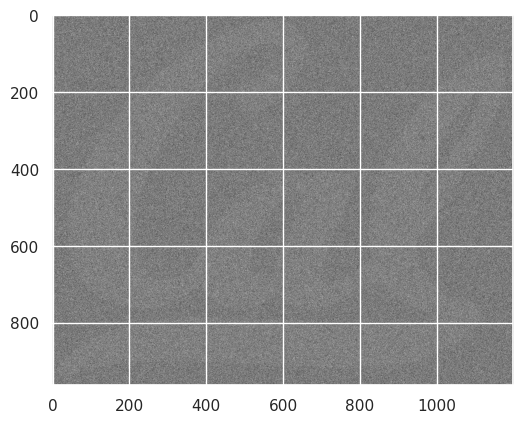

In [4]:
plt.imshow(X, cmap = "gray")

### 2D

In [5]:
n, m = X.shape[0], X.shape[1]

def get_neighbors(Z, row, col, trows = n, tcols = m):
    neighs = []
    
    if (row - 1 >= 0): # top
        neighs.append(Z[row - 1, col])
    if (row + 1 < trows): # bottom
        neighs.append(Z[row + 1, col])
    if (col - 1 >= 0): # left
        neighs.append(Z[row, col - 1])
    if (col + 1 < tcols): # right
        neighs.append(Z[row, col + 1])
        
    return neighs

def run_gibbs(n, m, X, T, alpha, beta, tau):
    Z = X
    for t in np.arange(T):
        for i in np.arange(n):
            for j in np.arange(m):
                S_ij = sum(get_neighbors(Z, i, j))
                Z[i, j] = ((1 / (alpha + tau)**0.5) * np.random.randn()) + (((tau * X[i, j]) + (beta * S_ij)) / (alpha + tau))  
    return Z

In [6]:
%time Z = run_gibbs(n, m, X, 1, 250, 62.5, 0.01)

CPU times: user 4.69 s, sys: 4.3 ms, total: 4.69 s
Wall time: 4.68 s


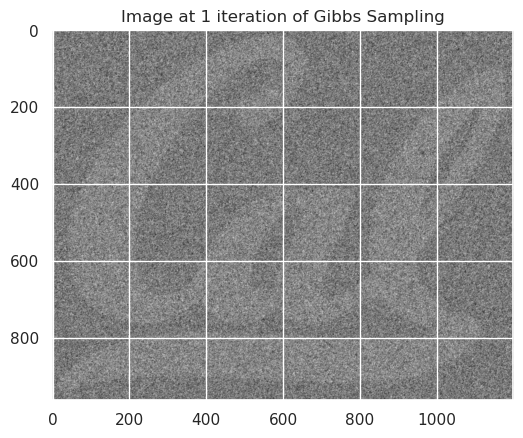

In [7]:
plt.imshow(Z, cmap = "gray")
plt.title("Image at 1 iteration of Gibbs Sampling");

In [8]:
%time Z = run_gibbs(n, m, X, 10, 250, 62.5, 0.01)

CPU times: user 47.2 s, sys: 54.3 ms, total: 47.3 s
Wall time: 47.3 s


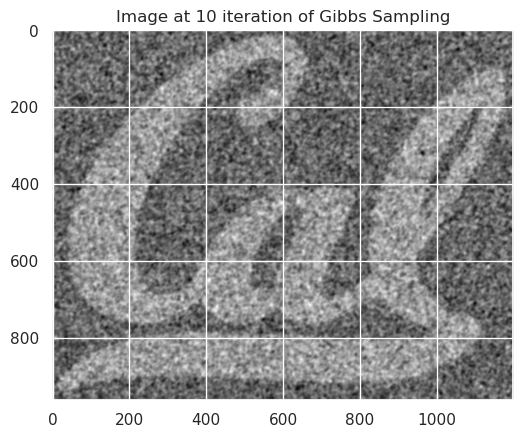

In [9]:
plt.imshow(Z, cmap = "gray")
plt.title("Image at 10 iteration of Gibbs Sampling");

It took 4.64s to run 1 iteration, and 45.2s to run 10 iterations. Therefore, it seems that 100 iterations will take approximately 450-460 seconds if assuming that the sampling algorithm is linear with iterations. 

### 2D

With Blocked Gibbs Sampling, the variable of interest is split up into blocks and then updated in sequence. In our case, it's possible to update multiple variables within a block simultaneously. In the case of updating the evens and odds independentl, this is justified because these the neighbors are conditionally independent given the values of the other variables in the model. 

The conditional distribution of given the values of the other variables is the same whether the odd neighbors are updated, or the even neighbors are updated. Therefore, updating half the variables at once doesn't change the resulting distribution, and can lead to more efficient sampling especially if we vectorize.

### 2E

In [24]:
def run_blocked_gibbs(n, m, X, T, alpha, beta, tau):
    n = X.shape[0]
    m = X.shape[1]
    Z = X
    X_updated = (tau / (alpha + tau)) * X
    n_pad = n + 2
    m_pad = m + 2

    
    for t in np.arange(T):
        S = Z.copy()
        S = np.pad(S, 1)


        up = np.insert(S[1:, :], n_pad - 1, values=0, axis=0)
        down = np.insert(S[:-1, :], 0, values=0, axis=0)
        left = np.insert(S[:, 1:], m_pad-1, values=0, axis=1)
        right = np.insert(S[:, :-1], 0, values=0, axis=1)
        S = up + down + left + right
        S = S[1:n_pad-1, 1:m_pad-1]
        
        delta = np.random.randn(n, m) * (1 / (alpha + tau))
        
        rows, cols = np.meshgrid(np.arange(n), np.arange(m), indexing = "ij")
        
        even_mask = (rows + cols) % 2 == 0
        S_even = np.zeros((n, m))
        S_even[even_mask] = S[even_mask]
        X_even = np.zeros((n, m))
        X_even[even_mask] = X_updated[even_mask]
        delta_even = np.zeros((n, m))
        delta_even[even_mask] = delta[even_mask]
        Z = X_even + (S_even * (beta / (alpha + tau))) + delta_even
        
        odd_mask = (rows + cols) % 2 == 1
        
        S = Z.copy()

        S = np.pad(S, 1)



        up = np.insert(S[1:, :], n_pad - 1, values = 0, axis = 0)
        down = np.insert(S[:-1, :], 0, values=0, axis=0)
        left = np.insert(S[:, 1:], m_pad - 1, values = 0, axis = 1)
        right = np.insert(S[:, :-1], 0, values = 0, axis = 1)
        S = up + down + left + right
        S = S[1:n_pad - 1, 1:m_pad - 1]
        S_odd = np.zeros((n, m))
        S_odd[odd_mask] = S[odd_mask]
        X_odd = np.zeros((n, m))
        X_odd[odd_mask] = X_updated[odd_mask]
        delta_odd = np.zeros((n, m))
        delta_odd[odd_mask] = delta[odd_mask]
        Z = X_odd + (S_odd * (beta / (alpha + tau))) + delta_odd
    return Z

### 2F

In [25]:
%time Z = run_blocked_gibbs(n, m, X, 100, 250, 62.5, 0.01)

CPU times: user 16.3 s, sys: 251 ms, total: 16.6 s
Wall time: 16.6 s


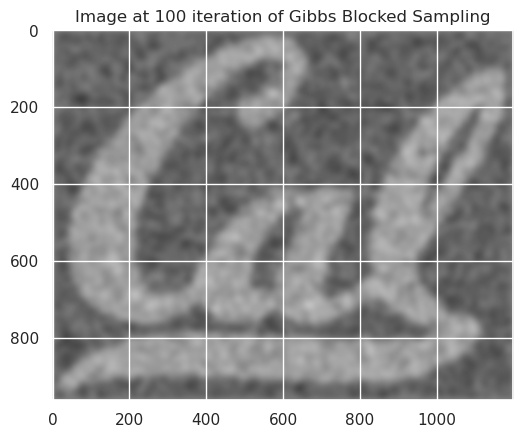

In [26]:
plt.imshow(Z, cmap = "gray")
plt.title("Image at 100 iteration of Gibbs Blocked Sampling");

## 3

In [14]:
elections = pd.read_csv("us_elections.csv")

In [15]:
elections

,district,trump16_margin,obama12_margin,house_dem18_margin,house_dem_avg_margin,rpt,incumbent_party,safety,house_dem20_margin,house20_winner,govtrack_ideology,last_name
0,AK-AL,0.152,-0.141,-0.065848,-0.165514,0.51,R,Vulnerable,-0.264,Rep,0.576742,b'Young'
1,AL-1,0.294,-0.244,-0.263798,-0.642656,0.88,R,Safe,-0.360,Rep,0.768097,b'Byrne'
2,AL-2,0.319,-0.265,-0.229625,-0.233190,0.94,R,Safe,-0.307,Rep,0.554987,b'Roby'
3,AL-3,0.330,-0.255,-0.274989,-0.305166,0.76,R,Safe,-0.378,Rep,0.592498,b'Rogers'
4,AL-4,0.630,-0.508,-0.596457,-0.762051,0.91,R,Safe,-0.658,Rep,0.599342,b'Aderholt'
...,...,...,...,...,...,...,...,...,...,...,...,...
426,WI-8,0.176,-0.037,-0.274185,-0.237034,0.82,R,Safe,-0.308,Rep,0.706871,b'Gallagher'
427,WV-1,0.416,-0.267,-0.291503,-0.299911,0.91,R,Safe,-0.375,Rep,0.669251,b'McKinley'
428,WV-2,0.364,-0.220,-0.109833,-0.175190,0.97,R,Safe,-0.262,Rep,0.891064,b'Mooney'
429,WV-3,0.492,-0.322,-0.127468,-0.148480,0.93,R,Safe,-0.428,Rep,0.656066,b'Miller'


In [16]:
with pm.Model() as gaussian_model:
    priors = {
          "Regressor": pm.Normal.dist(mu=0, sd=1)
          }
    glm.GLM.from_formula('house_dem20_margin ~ 0 + govtrack_ideology + house_dem18_margin', elections, priors = priors)
    # draw posterior samples using NUTS sampling
    trace = pm.sample(1000, cores = 2, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, house_dem18_margin, govtrack_ideology]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [17]:
first = trace.posterior[["govtrack_ideology", "house_dem18_margin"]].to_dataframe()

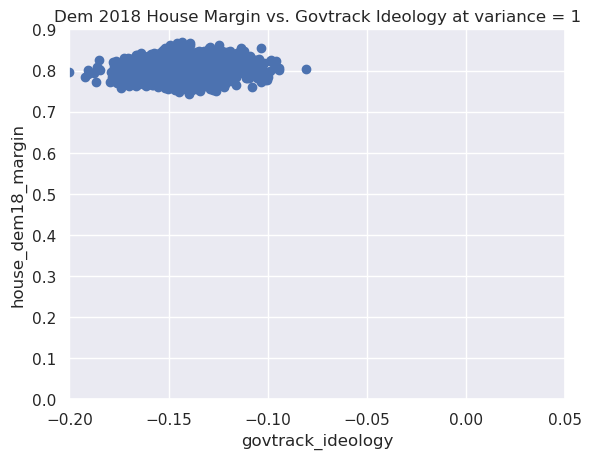

In [18]:
plt.scatter(first["govtrack_ideology"], first["house_dem18_margin"])
plt.xlabel("govtrack_ideology")
plt.ylabel("house_dem18_margin");
plt.title("Dem 2018 House Margin vs. Govtrack Ideology at variance = 1")
plt.xlim([-0.2, 0.05])
plt.ylim([0, 0.9]);

In [19]:
with pm.Model() as gaussian_model:
    priors = {
          "Regressor": pm.Normal.dist(mu=0, sd=np.sqrt(.01))
          }
    glm.GLM.from_formula('house_dem20_margin ~ 0 + govtrack_ideology + house_dem18_margin', elections, priors = priors)
    # draw posterior samples using NUTS sampling
    trace = pm.sample(1000, cores = 2, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, house_dem18_margin, govtrack_ideology]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [20]:
second = trace.posterior[["govtrack_ideology", "house_dem18_margin"]].to_dataframe()

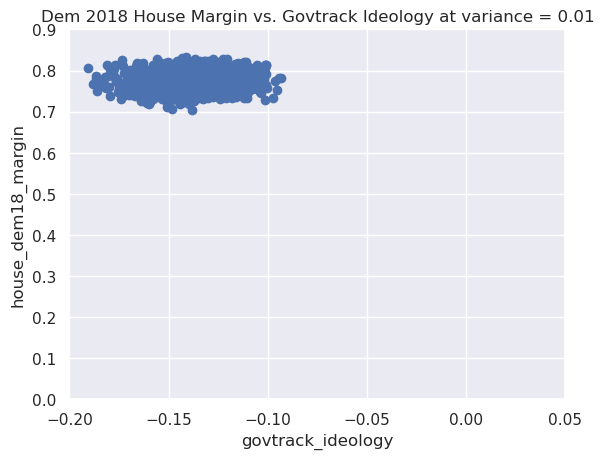

In [21]:
plt.scatter(second["govtrack_ideology"], second["house_dem18_margin"])
plt.xlabel("govtrack_ideology")
plt.ylabel("house_dem18_margin");
plt.title("Dem 2018 House Margin vs. Govtrack Ideology at variance = 0.01")
plt.xlim([-0.2, 0.05])
plt.ylim([0, 0.9]);

In [28]:
with pm.Model() as gaussian_model:
    priors = {
          "Regressor": pm.Normal.dist(mu=0, sd=np.sqrt(10**-4))
          }
    glm.GLM.from_formula('house_dem20_margin ~ 0 + govtrack_ideology + house_dem18_margin', elections, priors = priors)
    # draw posterior samples using NUTS sampling
    trace = pm.sample(1000, cores = 2, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, house_dem18_margin, govtrack_ideology]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [29]:
third = trace.posterior[["govtrack_ideology", "house_dem18_margin"]].to_dataframe()

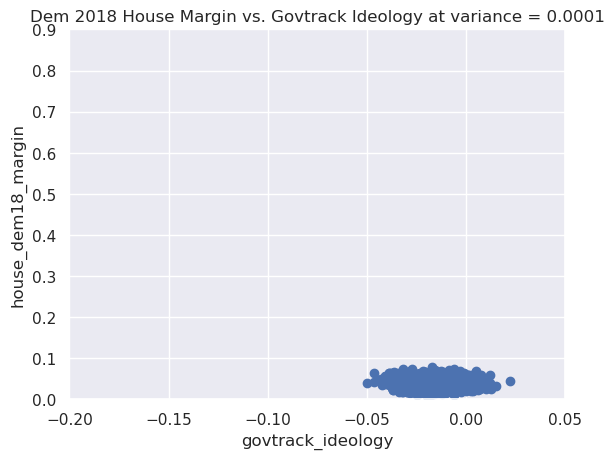

In [30]:
plt.scatter(third["govtrack_ideology"], third["house_dem18_margin"])
plt.xlabel("govtrack_ideology")
plt.ylabel("house_dem18_margin");
plt.title("Dem 2018 House Margin vs. Govtrack Ideology at variance = 0.0001")
plt.xlim([-0.2, 0.05])
plt.ylim([0, 0.9]);

### 3B

Note: when saying beta, I mean beta variable, not Beta distribution.

The scatterplots that show the models with beta variance 1 and 0.01 have similar results, while the scatterplot of the model with beta variance 0.0001 is greatly different. This is because a beta regressor random variable with an extremely small variance and a mean of 0 will result in a multiplicative factor close to 0 for both x variables used. Compared to the beta with variance 1 and variance 0.01, a beta with variance 0.0001 will result in a sample drawn from a Normal distribution with a very sharp peak at 0, and very very little spread. Hence, the third scatterplot displays the results of a model that shows the beta coefficients for both house_dem18_margin and govtrack_ideology concentrated around values close to 0, while the other two scatterplots have values similarly grouped at non-zero values.

### 3C

When using a very small value of sigma_0, we are assuming that the outcome of the 2018 election for House Dems and the officeholder's ideology both have a very specific effect on the 2020 election outcome for House Dems. This can be interpreted differently based on the average of the beta coefficients, the two of which are multiplied with 2018 election outcome and officeholder ideology, respectively, in the GLM model. If the average is 0, we can say that our assumption is that the two X variables have a very specific, neglible impact on the 2020 outcome; vice versa, if the average is a non-zero number, we can say that our assumption is that the two X variables have a very specific, non-zero impact on the 2020 outcome.